# Visualizing and Understanding Convolutional Networks

https://www.youtube.com/watch?v=6wcs6szJWMY

http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture12.pdf

http://cs231n.github.io/understanding-cnn/

## ACTIVATIONS METHODS:

### Nearest neighbours

capa final antes de la fully conected: MUY IMPORTANTE FEATURE MAP
-Nearest neighbor images in that 4095 dimensional feature space (last conv layer de alexnet)

En una imagen de un elefante se pie y otro tumbado, los pixeles son casi completamente diferentes (en apariencia)
Pero, en el FEATURE SPACES, que es apredido por la red, ambas imágenes son similares

### Dimensionality Reduction:

Visualizar el feature vector en vez de en 4096 dimensiones, en 2:
-PCA:
-t-SNE:

### Intermediate layers:

No es interesante mirar los pesos.
En cambio si los es mirar los mapas de activación.

### Maximaly activating patches

Mirar que trozos de la imagen de entrada causan una máxima activación en diferentes neuronas.
***en cnns todas las neuronas de un canal tienen los mismos pesos***

### Occlusion Experiments

Descifrar que partes de la imagen de entrada causan las decisiones de clasificacion de la CNN

Para ello se pasa un filtro (que actua a modo de parche) por toda la imagen, guardando los resultados de la clasificación para cada caso.

## GRADIENTS METHODS:

### Silency Maps:

Cómo decir que pixeles son importantes para la clasificación? Kren's Paper
Combinada con Grabcut Segmentation algorithm segmenta el objeto en la imagen

### Guided backprop

Zeiler and Fergus's 2014 paper

back propagate only positive ReLU's

Se obtienen imágenes mucho más limpias.

Aplicado a los parches de activación, nos ayuda a saber que parte concreta interviene en la activación de la neurona.

### Gradient Ascend:

Generar imágenes sintética (colores raros)

jason yesenski paper 

### Fooling images/Adversarial images

Lecture of Ian goodfellow

# Visualización de filtros y mapas de características (feature maping)

### GPU disponible:

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


### Creación del modelo:

Se va a usar la redd VGG16 a la que se ha añadido una top-layer entrenada con muestras de 3 clases de granos de polen:

In [2]:
import sys
import os
from PIL import Image
from matplotlib import pyplot
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers import  Convolution2D, MaxPooling2D, Dense, GlobalAveragePooling2D, AveragePooling2D
from keras.models import Model, load_model
from keras import backend as K
from keras import applications
from keras.applications.vgg16 import preprocess_input
K.clear_session()

baseModel = applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))#Cargamos la red
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Se cargan los pesos guardados de la red anteriormente comentada:

In [3]:
pesos_modelo = './VGG16_3class/pesos_VGG16_3class.h5'
model.load_weights(pesos_modelo)

In [4]:
# summarize feature map shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

1 block1_conv1 (?, 256, 256, 64)
2 block1_conv2 (?, 256, 256, 64)
4 block2_conv1 (?, 128, 128, 128)
5 block2_conv2 (?, 128, 128, 128)
7 block3_conv1 (?, 64, 64, 256)
8 block3_conv2 (?, 64, 64, 256)
9 block3_conv3 (?, 64, 64, 256)
11 block4_conv1 (?, 32, 32, 512)
12 block4_conv2 (?, 32, 32, 512)
13 block4_conv3 (?, 32, 32, 512)
15 block5_conv1 (?, 16, 16, 512)
16 block5_conv2 (?, 16, 16, 512)
17 block5_conv3 (?, 16, 16, 512)


## MUESTRA1

### Procesado de la imagen:

In [73]:
# load the image with the required shape
img = load_img('Muestra1.jpg', target_size=(256, 256))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)

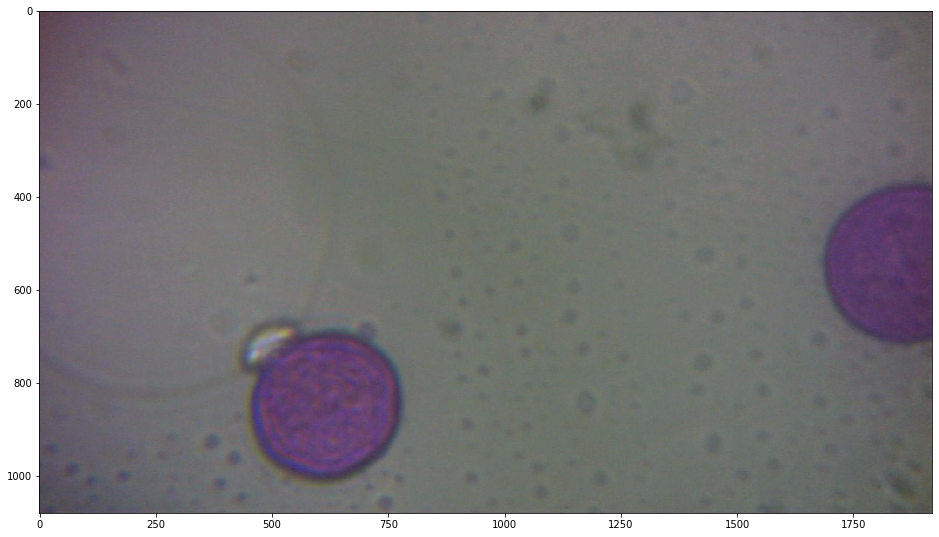

In [33]:
img = load_img('Muestra1.jpg')
pyplot.figure(figsize=(16,11))
pyplot.imshow(img)
pyplot.show(img)

### Model that outputs a feature map from the first convolutional layer

In [16]:
# redefine model to output right after the first hidden layer
model_1FM = Model(inputs=model.inputs, outputs=model.layers[1].output)
# get feature map for first hidden layer
feature_maps = model_1FM.predict(img)

El resultado será un mapa de características de dimensiones 256x256x64

Se dibujarán todas las 64 imágenes 2D en cuadros de 8x8:

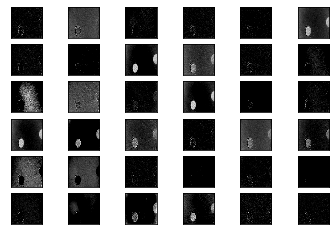

In [49]:
# plot all 64 maps in an 8x8 squares
square = 6
ix = 1 #Solo se cogerá la primera capa conv
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
pyplot.savefig('conv1.jpg')
# show the figure
pyplot.show()


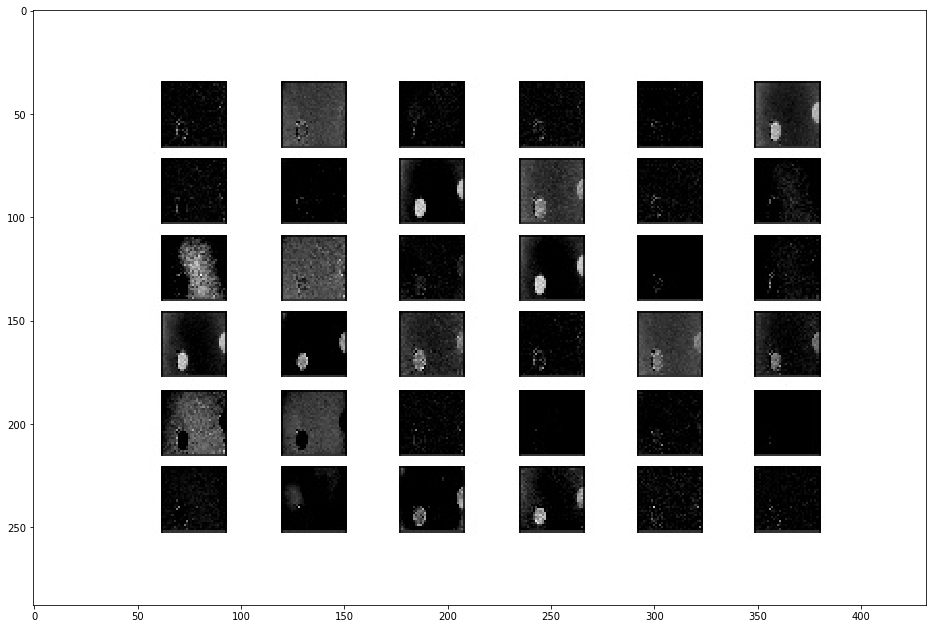

In [51]:
img = load_img('conv1.jpg')
pyplot.figure(figsize=(16,11))
pyplot.imshow(img)
pyplot.show(img)

El modelo usado es mucho más pequeño que VGG16 pero usa los mismos pesos (filtros) en la primera capa conv que VGG16

### Model that outputs a feature map from the last convolutional layer

In [ ]:
# redefine model to output right after the first hidden layer
model_LastFM = Model(inputs=model.inputs, outputs=model.layers[17].output)

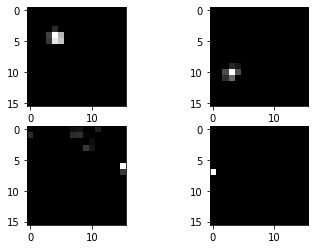

In [69]:
# load the image with the required shape
img = load_img('Muestra1.jpg', target_size=(256, 256))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)

# get feature map for first hidden layer
feature_maps = model_LastFM.predict(img)

# plot all 64 maps in an 8x8 squares
square = 2
ix = 1 #Solo se cogerá la primera capa conv
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        #ax.set_xticks([])
        #ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
pyplot.savefig('convLast.jpg')
# show the figure
pyplot.show()

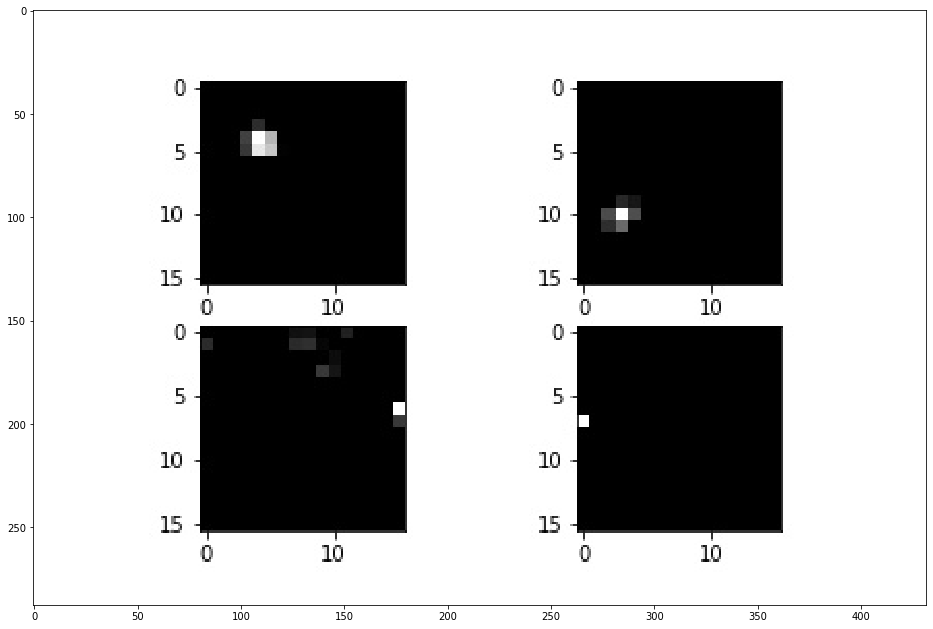

In [70]:
img = load_img('convLast.jpg')
pyplot.figure(figsize=(16,11))
pyplot.imshow(img)
pyplot.show(img)

In [72]:
feature_maps.shape

(1, 16, 16, 512)

### Model that outputs a feature map from the last intermediate layer

In [79]:
# redefine model to output right after the first hidden layer
model_IntermFM = Model(inputs=model.inputs, outputs=model.layers[11].output)

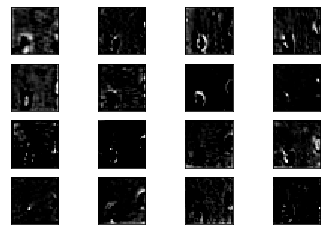

In [84]:
# load the image with the required shape
img = load_img('Muestra1.jpg', target_size=(256, 256))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)

# get feature map for first hidden layer
feature_maps = model_IntermFM.predict(img)

# plot all 64 maps in an 8x8 squares
square = 4
ix = 1 #Solo se cogerá la primera capa conv
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
pyplot.savefig('convInterm.jpg')
# show the figure
pyplot.show()

### Modelo con todas las capas conv del modelo de partida (conservando pesos)

In [74]:
# visualize feature maps output from each block in the vgg model
#from keras.applications.vgg16 import VGG16
#from keras.applications.vgg16 import preprocess_input
#from keras.preprocessing.image import load_img
#from keras.preprocessing.image import img_to_array
#from keras.models import Model
#from matplotlib import pyplot
#from numpy import expand_dims
###############################################################

# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model_AllFM = Model(inputs=model.inputs, outputs=outputs)

###############################################################
# load the image with the required shape
#img = load_img('bird.jpg', target_size=(224, 224))
# convert the image to an array
#img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
#img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
#img = preprocess_input(img)
###############################################################

Para el caso anterior, teníamos 64 feature maps, pero no es así en todas las capa (pueden ser 128, 256 o 512). Como son demasiados para representarlos, se representarán para todos los casos 64

Si se ejecuta la siguiente parte del código se obtiene como resultado 5 gráficas de 64 feature maps cada una, obtenidas de los cinco bloques principales de VGG16

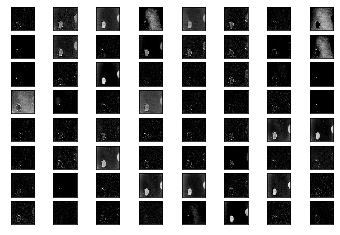

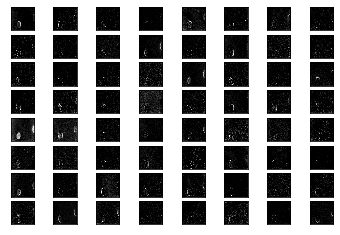

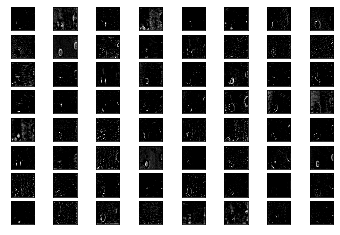

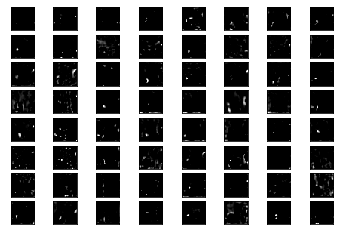

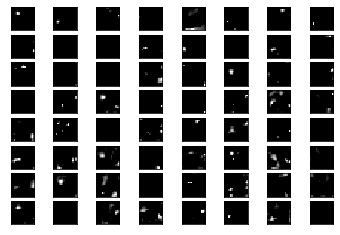

In [76]:
# get feature map for first hidden layer
feature_maps = model_AllFM.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()

In [77]:
print(feature_maps)

[array([[[[0.00000000e+00, 0.00000000e+00, 6.23860703e+01, ...,
          0.00000000e+00, 0.00000000e+00, 8.01643753e+01],
         [1.38968410e+01, 0.00000000e+00, 1.04566689e+02, ...,
          2.47414951e+01, 0.00000000e+00, 6.20680580e+01],
         [0.00000000e+00, 0.00000000e+00, 1.15074165e+02, ...,
          3.37312851e+01, 4.53864784e+01, 2.07813854e+01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 7.28212891e+01, ...,
          0.00000000e+00, 0.00000000e+00, 1.67515640e+01],
         [2.87139721e+01, 0.00000000e+00, 6.27437325e+01, ...,
          8.99141598e+00, 0.00000000e+00, 5.95908394e+01],
         [1.50329422e+02, 2.98271923e+01, 3.48250275e+01, ...,
          1.35777216e+01, 1.42222717e+02, 3.11858177e+01]],

        [[2.78910389e+01, 0.00000000e+00, 1.10788979e+02, ...,
          4.60256653e+01, 0.00000000e+00, 2.01824417e+01],
         [2.68727417e+02, 2.76475372e+02, 1.90282333e+02, ...,
          1.65536285e+02, 0.00000000e+00, 0.00000000e+00],
       

## MUESTRA6:

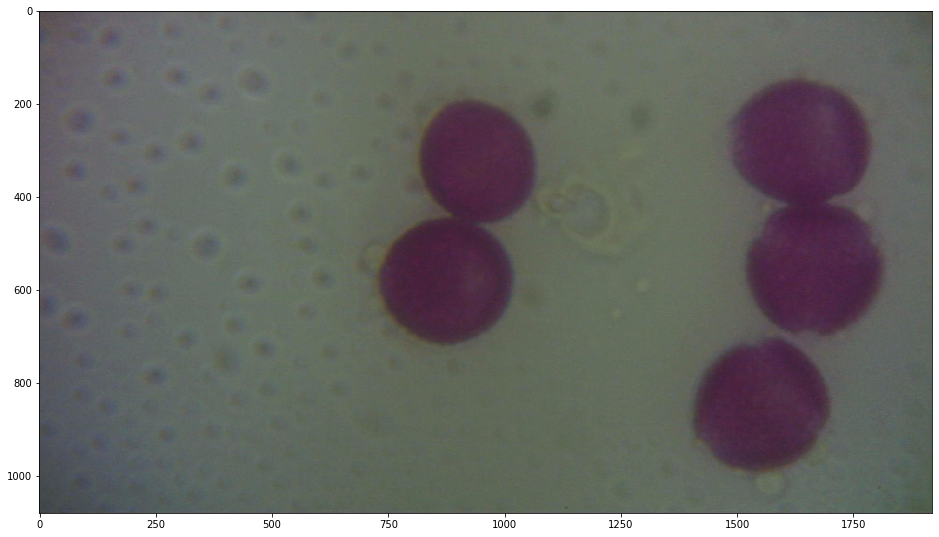

In [88]:
img = load_img('Muestra6.jpg')
pyplot.figure(figsize=(16,11))
pyplot.imshow(img)
pyplot.show(img)

In [85]:
# redefine model to output right after the first hidden layer
model_IntermFM = Model(inputs=model.inputs, outputs=model.layers[11].output)

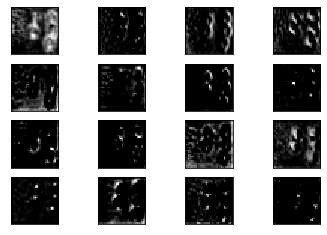

In [86]:
# load the image with the required shape
img = load_img('Muestra6.jpg', target_size=(256, 256))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)

# get feature map for first hidden layer
feature_maps = model_IntermFM.predict(img)

# plot all 64 maps in an 8x8 squares
square = 4
ix = 1 #Solo se cogerá la primera capa conv
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
pyplot.savefig('convIntermM6.jpg')
# show the figure
pyplot.show()

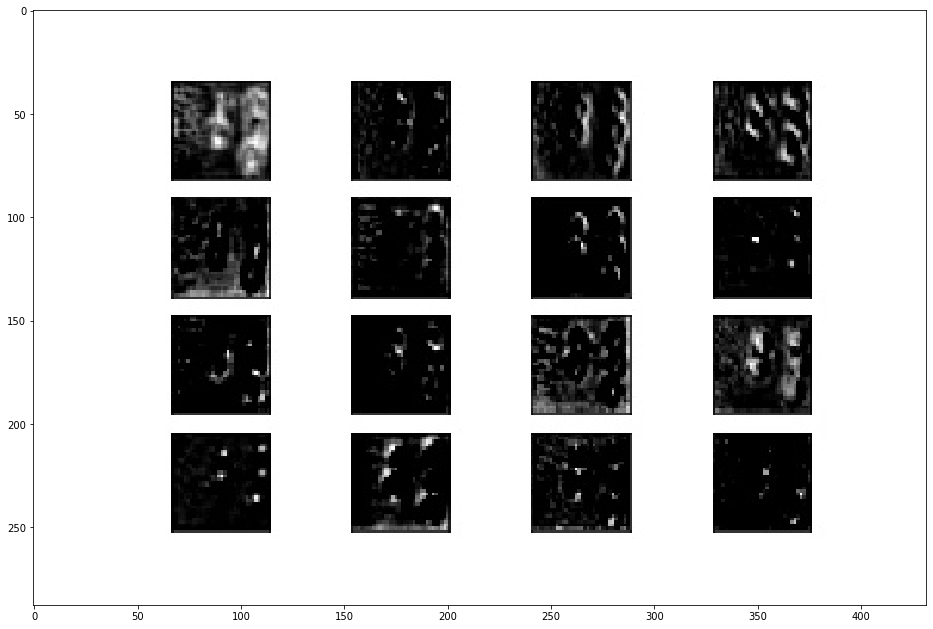

In [87]:
img = load_img('convIntermM6.jpg')
pyplot.figure(figsize=(16,11))
pyplot.imshow(img)
pyplot.show(img)

### Mostrar Feature map de todas las capas:

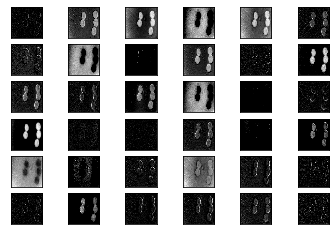

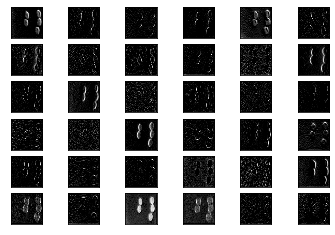

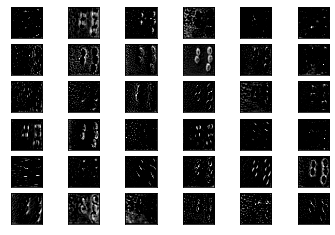

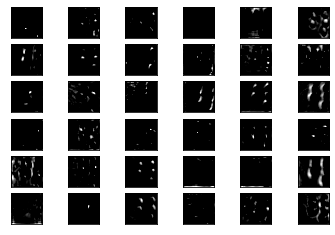

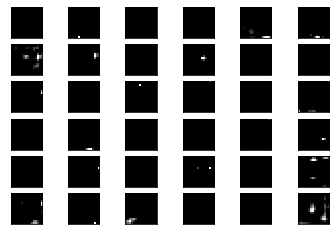

In [90]:
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model_AllFM = Model(inputs=model.inputs, outputs=outputs)

# load the image with the required shape
img = load_img('Muestra6.jpg', target_size=(256, 256))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)

# get feature map for first hidden layer
feature_maps = model_AllFM.predict(img)
# plot the output from each block
square = 6
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()